**Rationale for Choice of ML Model**

LSTM was chosen because stock prices is a time series model. LSTM has the ability to provide greater accuracy in predicting future values baased on previous, sequential data. 

**Importing required libaries and dependencies**

In [61]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import L2
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
import matplotlib.pyplot as plt

from sklearn import preprocessing

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


**Importing data**

In [3]:
path = "/content/drive/MyDrive/Colab Notebooks/NUS_FinTech/Project1/NVDA.csv"
df_NVDA = pd.read_csv(path)

**Because we want to forecast for the next 2 weeks, better to use data that is more recent, hence filter for dates > 2020-01-01 **

In [13]:
df_NVDA = df_NVDA[(df_NVDA['Date'] > '2020-01-01')]
df_NVDA

,Date,Open,High,Low,Close,Adj Close,Volume
5269,2020-01-02,59.687500,59.977501,59.180000,59.977501,59.785843,23753600
5270,2020-01-03,58.775002,59.457500,58.525002,59.017502,58.828907,20538400
5271,2020-01-06,58.080002,59.317501,57.817501,59.264999,59.075619,26263600
5272,2020-01-07,59.549999,60.442501,59.097500,59.982498,59.790829,31485600
5273,2020-01-08,59.939999,60.509998,59.537498,60.095001,59.902973,27710800
...,...,...,...,...,...,...,...
5972,2022-10-17,115.180000,119.480003,115.169998,118.879997,118.879997,58077400
5973,2022-10-18,123.440002,124.919998,116.180000,119.669998,119.669998,65936200
5974,2022-10-19,118.790001,123.500000,118.339996,120.510002,120.510002,52313100
5975,2022-10-20,121.129997,127.690002,121.050003,121.940002,121.940002,65239800


**Data preprocessing and data manipulation**

In [14]:
closingPrice = df_NVDA['Close'].to_numpy()

In [15]:
#model requires input array to be in 3D
features = np.array(closingPrice).reshape(-1,1)

In [17]:
#Performing Min-Max scaling on dataset
sc = preprocessing.MinMaxScaler().fit(features)
scaled_features = sc.transform(features)

**Data Visualization**

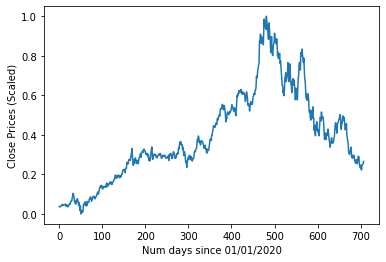

In [59]:
for i in range(len(scaled_features[0])):
  plt.plot(scaled_features[...,i], label= i)
  plt.xlabel("Num days since 01/01/2020")
  plt.ylabel("Close Prices (Scaled)")

In [19]:
#Process of generating input data
#Predictor will consist of 40 consecutive days of closing prices in order to predict closing price over a period of 10 days

sampleLength = 40
forecast_days = 10
x = []
y = []
for i in range(len(closingPrice)-sampleLength-forecast_days):
  x += [scaled_features[i:i+sampleLength]]
  y += [closingPrice[i+sampleLength+forecast_days-1]]

x = np.array(x)
y = np.array(y)

#x is the feature vector and has dimensions: (numRows, 40, 1)
#y is the output vector and has dimensions: (numRows, 1)

y = y[..., np.newaxis]

**Train-Test Split**

In [20]:
#test set will be the last 50 trading days recorded
testLength = 50
trainLength = len(x) - testLength
trainX, trainY, testX, testY = x[:trainLength], y[:trainLength], x[trainLength:], y[trainLength:]

**Training the model**

Model Architecture:
Stacked LSTM (4 LSTM layers in total) with BatchNormalisation and Dropout layer after each LSTM followed by a Dense layer

In [32]:
model = Sequential([
    LSTM(50, input_shape=(sampleLength,features.shape[1]), return_sequences = True),
    BatchNormalization(),
    Dropout(0.25),
    LSTM(50, return_sequences = True),
    BatchNormalization(),
    Dropout(0.25),
    LSTM(50, return_sequences = True),
    BatchNormalization(),
    Dropout(0.25),
    LSTM(50),
    BatchNormalization(),
    Dropout(0.25),
    Dense(1, activation="linear")
])

opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)

model.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["mse"]
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 40, 50)            10400     
                                                                 
 batch_normalization_7 (Batc  (None, 40, 50)           200       
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 40, 50)            0         
                                                                 
 lstm_8 (LSTM)               (None, 40, 50)            20200     
                                                                 
 batch_normalization_8 (Batc  (None, 40, 50)           200       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 40, 50)           

In [33]:
history = model.fit(
    trainX, 
    trainY,
    validation_data = (testX, testY),
    epochs = 60,
    batch_size = 32)

Epoch 1/60
19/19 [==============================] - 9s 167ms/step - loss: 32364.2129 - mse: 32364.2129 - val_loss: 20563.6426 - val_mse: 20563.6426
Epoch 2/60
19/19 [==============================] - 1s 74ms/step - loss: 31923.3750 - mse: 31923.3750 - val_loss: 20492.9258 - val_mse: 20492.9258
Epoch 3/60
19/19 [==============================] - 1s 74ms/step - loss: 31713.0059 - mse: 31713.0059 - val_loss: 20335.1055 - val_mse: 20335.1055
Epoch 4/60
19/19 [==============================] - 1s 73ms/step - loss: 31486.0566 - mse: 31486.0566 - val_loss: 20126.4824 - val_mse: 20126.4824
Epoch 5/60
19/19 [==============================] - 1s 73ms/step - loss: 31238.0332 - mse: 31238.0332 - val_loss: 19956.1641 - val_mse: 19956.1641
Epoch 6/60
19/19 [==============================] - 1s 72ms/step - loss: 30985.5879 - mse: 30985.5879 - val_loss: 19860.9668 - val_mse: 19860.9668
Epoch 7/60
19/19 [==============================] - 1s 72ms/step - loss: 30668.9941 - mse: 30668.9941 - val_loss: 192

**Retraining model with early stopping**

Use of early stopping to ensure that the weights of the model have minimum validation loss in order to prevent overfitting of the model. also identifies the epoch corresponding to the lowest validation loss

In [28]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights = True)]

In [38]:
history = model.fit(
    trainX, 
    trainY,
    validation_data = (testX, testY),
    epochs = 200,
    batch_size = 32,
    callbacks = callbacks)

#In total first 60 epochs without callback, subsequent 200 epochs conducted with callback

Epoch 1/200
19/19 [==============================] - 1s 75ms/step - loss: 5201.2417 - mse: 5201.2417 - val_loss: 2545.8191 - val_mse: 2545.8191
Epoch 2/200
19/19 [==============================] - 2s 102ms/step - loss: 4840.0527 - mse: 4840.0527 - val_loss: 2445.5684 - val_mse: 2445.5684
Epoch 3/200
19/19 [==============================] - 2s 108ms/step - loss: 4493.3330 - mse: 4493.3330 - val_loss: 2045.5625 - val_mse: 2045.5625
Epoch 4/200
19/19 [==============================] - 1s 73ms/step - loss: 4228.1587 - mse: 4228.1587 - val_loss: 1101.5079 - val_mse: 1101.5079
Epoch 5/200
19/19 [==============================] - 2s 83ms/step - loss: 4006.5613 - mse: 4006.5613 - val_loss: 3303.3853 - val_mse: 3303.3853
Epoch 6/200
19/19 [==============================] - 2s 84ms/step - loss: 3658.4561 - mse: 3658.4561 - val_loss: 1246.0812 - val_mse: 1246.0812
Epoch 7/200
19/19 [==============================] - 2s 95ms/step - loss: 3286.5815 - mse: 3286.5815 - val_loss: 1112.6641 - val_mse: 

**Assessing the performance of the model, MSE was used as the evaluation metric.**

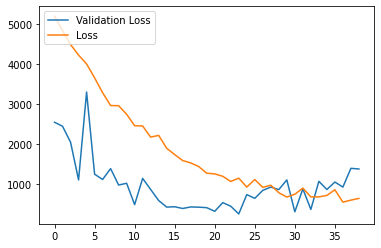

In [39]:
plt.plot(history.history['val_mse'], label = 'Validation Loss')
plt.plot(history.history['mse'], label = 'Loss')
plt.legend(loc="upper left")

**Data Visualisation of Predicted Closing Price versus Actual Closing Price for model trained on training data**

19/19 [==============================] - 0s 23ms/step


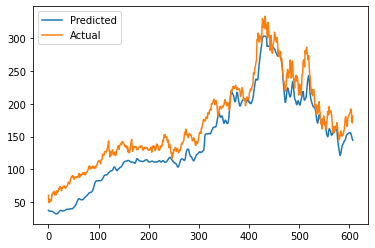

In [40]:
predicted = model.predict(trainX)
plt.plot(predicted, label = 'Predicted')
plt.plot(trainY, label = 'Actual')
plt.legend(loc="upper left")

**Data Visualisation of Predicted Closing Price and Actual Closing Price for model trained on testing data**

2/2 [==============================] - 2s 21ms/step


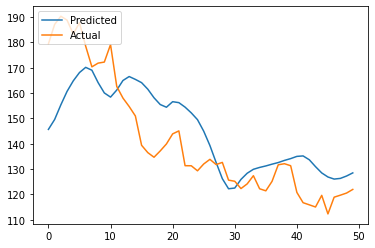

In [41]:
predicted = model.predict(testX)
plt.plot(predicted, label = 'Predicted')
plt.plot(testY, label = 'Actual')
plt.legend(loc="upper left")

In [60]:
model.save("/content/drive/MyDrive/Fintech Proj 1")

**Model Prediction of Closing Price for next 10 trading days (24 October 2022 - 4 November 2022)**

In [54]:
forecast_input = []
for i in range(10):
  forecast_input += [scaled_features[-sampleLength-i-1:-i-1]]

forecast_input = np.array(forecast_input)
forecast_input = forecast_input[::-1]

In [55]:
output_prediction = model.predict(forecast_input)
output_prediction

1/1 [==============================] - 0s 29ms/step


array([[128.76231 ],
       [127.82897 ],
       [126.08418 ],
       [124.04498 ],
       [122.51426 ],
       [120.622   ],
       [119.1206  ],
       [117.758316],
       [116.098564],
       [113.75536 ]], dtype=float32)

In [57]:
pd.DataFrame(output_prediction).to_csv("BrandonNeoBingJie_Impl_1.csv")